## Imports

In [32]:
import time
import os
import random
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

%matplotlib inline

## GPU selection (for non Google Colab)
Uncomment the following line and change the index of GPU you want to use. 
Indeces start from '0'. You should only use one GPU for this project.


In [57]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

## Load data (for Google Colab only)
If you are using google colab, these codes help you easily load data.

**Rememeber to change runtime type to GPU if you are using google colab.**

Please store the dataset floder ([data](https://drive.google.com/drive/folders/1_0Doj4SmfqSNSm9CeMqNlagfb4APLQfq?usp=sharing)) to the root of your google drive first.
Then uncomment the codes, run them and follow the instruction to mount your google drive.

In [58]:
# assert os.environ['COLAB_GPU'], 'Make sure to select GPU from Edit > Notebook settings > Hardware accelerator'
from google.colab import drive
 drive.mount('/content/drive')

Then link the `data` in google drive to `./data`

In [59]:
!rm -f data
!ln -s '/content/drive/My Drive/data' data

## Some utilities

In [60]:
def to_2d_tensor(inp):
    inp = torch.Tensor(inp)
    if len(inp.size()) < 2:
        inp = inp.unsqueeze(0)
    return inp

def box_transform_inv(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = (boxes[:, 0] + 1) / 2 * im_sizes[:, 0]
    boxes[:, 1] = (boxes[:, 1] + 1) / 2 * im_sizes[:, 1]
    boxes[:, 2] = boxes[:, 2] / 2 * im_sizes[:, 0]
    boxes[:, 3] = boxes[:, 3] / 2 * im_sizes[:, 1]
    return boxes

def box_transform(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = 2 * boxes[:, 0] / im_sizes[:, 0] - 1
    boxes[:, 1] = 2 * boxes[:, 1] / im_sizes[:, 1] - 1
    boxes[:, 2] = 2 * boxes[:, 2] / im_sizes[:, 0]
    boxes[:, 3] = 2 * boxes[:, 3] / im_sizes[:, 1]
    return boxes

def xywh_to_x1y1x2y2(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] += boxes[:, 0] - 1
    boxes[:, 3] += boxes[:, 1] - 1
    return boxes

def x1y1x2y2_to_xywh(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] -= boxes[:, 0] - 1
    boxes[:, 3] -= boxes[:, 1] - 1
    return boxes

def compute_IoU(boxes1, boxes2):
    boxes1 = to_2d_tensor(boxes1)
    boxes1 = xywh_to_x1y1x2y2(boxes1)
    boxes2 = to_2d_tensor(boxes2)
    boxes2 = xywh_to_x1y1x2y2(boxes2)
    
    intersec = boxes1.clone()
    intersec[:, 0] = torch.max(boxes1[:, 0], boxes2[:, 0])
    intersec[:, 1] = torch.max(boxes1[:, 1], boxes2[:, 1])
    intersec[:, 2] = torch.min(boxes1[:, 2], boxes2[:, 2])
    intersec[:, 3] = torch.min(boxes1[:, 3], boxes2[:, 3])
    
    def compute_area(boxes):
        # in (x1, y1, x2, y2) format
        dx = boxes[:, 2] - boxes[:, 0]
        dx[dx < 0] = 0
        dy = boxes[:, 3] - boxes[:, 1]
        dy[dy < 0] = 0
        return dx * dy
    
    a1 = compute_area(boxes1)
    a2 = compute_area(boxes2)
    ia = compute_area(intersec)
    assert((a1 + a2 - ia <= 0).sum() == 0)
    
    return ia / (a1 + a2 - ia)    

def compute_acc(preds, targets, theta=0.75):
    IoU = compute_IoU(preds.clone(), targets.clone())
    corr = (IoU >= theta).sum()
    return corr.item() / preds.size(0)

class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        
def box_to_mask(box, im_size):
    mask = np.zeros(im_size)
    co = xywh_to_x1y1x2y2(box)[0].type(torch.int64)
    mask[co[0]: co[2], co[1]: co[3]] = 1
    return Image.fromarray(np.uint8(mask*255).T)

def mask_to_box(mask):
    mask = torch.nonzero(mask[0, :, :].T != 0, as_tuple=False)
    x1, y1 = torch.min(mask, dim=0).values
    x2, y2 = torch.max(mask, dim=0).values
    return x1y1x2y2_to_xywh([x1, y1, x2, y2])[0]
    

## Split dataset

In [61]:
def split(ratio):
    with open('data/train_test_split.txt') as f:
        lines = f.read().splitlines()
    class_groups = dict()
    train_id, test_id = [], []
    for line in lines:
        key, is_train = line.split(' ')
        if is_train == '1':
            train_id.append(key)
        else:
            test_id.append(key)
    with open('data/images.txt') as f:
        lines = f.read().splitlines()
    for line in lines:
        value, line = line.split(' ', 1)
        key = line.split('.', 1)[0]
        if value not in train_id:
            continue
        if key in class_groups:
            class_groups[key].append(value)
        else:
            class_groups[key] = [value]
    val_id = []
    for _, group in class_groups.items():
        val_id.extend(random.sample(group, int(math.ceil(len(group)*ratio))))
    train_id = [i for i in train_id if i not in val_id]
    return np.array(train_id), np.array(test_id), np.array(val_id)

## Define Dataset

In [62]:
class CUBDataset(Dataset):
    def __init__(self, im_ids, transform=None):
        with open('data/images.txt') as f:
            id_to_path = dict([l.split(' ', 1) for l in f.read().splitlines()])
        with open('data/bounding_boxes.txt') as f:
            id_to_box = dict()
            for line in f.read().splitlines():
                im_id, *box = line.split(' ')
                id_to_box[im_id] = list(map(float, box))
        self.imgs = [(os.path.join('data/images', id_to_path[i]), id_to_box[i])
                     for i in im_ids]
        self.target_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.transform = transforms.Compose([
            self.target_transform,
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        if transform is not None:
            self.transform = transforms.Compose([
                transform,
                self.transform
            ])
            self.target_transform = transforms.Compose([
                transform,
                self.target_transform
            ])
            
    def __getitem__(self, index):
        path, box = self.imgs[index]
        im = Image.open(path).convert('RGB')
        im_size = np.array(im.size, dtype='float32')
        box = np.array(box, dtype='float32')
        
        mask = box_to_mask(box, im.size)
        
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        im = self.transform(im)
        
        random.seed(seed)
        torch.manual_seed(seed)
        mask = self.target_transform(mask)
        
        box = mask_to_box(mask).numpy()

        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        
        return im, box
    
    def __len__(self):
        return len(self.imgs)
    

### Visualize training data

In [63]:
def imshow(img, gt_box, pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, color='red'):
        x, y, w, h = box
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        plt.gca().add_patch(
            plt.Rectangle((x, y), w, h,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
        
    draw_box(gt_box)
    if pred_box is not None:
        draw_box(pred_box, 'blue')
    plt.plot()

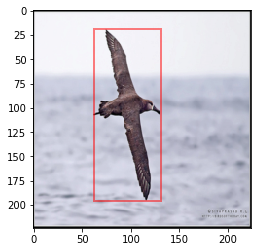

In [64]:
dataset = CUBDataset(['2'])
im, box = dataset[0]

inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

imshow(inp, box)

### Visualize result of output
If you need, this function can help you compare the result of your model and the ground truth.

In [65]:
def visualize_model(model, datasets):
    model = model.cpu()
    ind = random.choice(range(len(datasets['test'])))
    im, box = datasets['test'][ind]
    path, _ = datasets['test'].imgs[ind]

    pred_box = model(Variable(im.unsqueeze(0))).data[0]

    ori_im = Image.open(path)

    inp = im.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    box = box_transform_inv(box_transform(box, inp.shape[:2][::-1]), ori_im.size)[0]
    pred_box = box_transform_inv(box_transform(pred_box, inp.shape[:2][::-1]), ori_im.size)[0]
    imshow(ori_im, box, pred_box)

In [66]:
def plot(epoch_loss, epoch_acc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
    ax1.set_yscale('log')
    for phase in ('train', 'test'):
        ax1.plot(range(len(epoch_loss[phase])), epoch_loss[phase], label=(phase + '_loss'))
        ax2.plot(range(len(epoch_acc[phase])), epoch_acc[phase], label=(phase + '_acc'))
    ax1.legend(prop={'size': 15})
    ax2.legend(prop={'size': 15})

### Training Function

In [67]:
def train(model, dataloaders, optimizer, save_name=None, quite=False):
    # prepare data
    # construct model
    model = model.cuda()

    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_model_state = model.state_dict()
    best_epoch = -1
    best_acc = 0.0

    epoch_loss = {'train': [], 'test': [], 'val': []}
    epoch_acc = {'train': [], 'test': [], 'val': []}
    epochs = 20
    for epoch in range(epochs):
        accs = AverageMeter()
        losses = AverageMeter()
        for phase in dataloaders.keys():
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            end = time.time()
            for ims, boxes in tqdm(dataloaders[phase], desc=f'[{phase} {epoch+1}/{epochs}]', leave=False):
                inputs = Variable(ims.cuda())
                targets = Variable(boxes.cuda())
                
                loss, outputs = do_one_step(model, inputs, targets, optimizer, phase)
                
                acc = compute_acc(outputs.data.cpu(), targets.data.cpu())

                nsample = inputs.size(0)
                accs.update(acc, nsample)
                losses.update(loss.item(), nsample)

            if phase == 'val' and accs.avg > best_acc:
                best_acc = accs.avg
                best_epoch = epoch
                best_model_state = model.state_dict()
            elif phase == 'train':
                scheduler.step()
            elapsed_time = time.time() - end
            if not quite:
                print(f'[{phase}]\tEpoch: {epoch+1}/{epochs}'+
                    f'\tLoss: {losses.avg:.4f}\tAcc: {accs.avg:.2%}\tTime: {elapsed_time:.3f}')
            epoch_loss[phase].append(losses.avg)
            epoch_acc[phase].append(accs.avg)

    print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')
    if save_name is not None:
        torch.save(best_model_state, save_name)
        print(f'[Info] best model saved to {save_name}')
    return epoch_loss, epoch_acc

## Task1
In this task, you are required to load ImageNet-pretrained `ResNet-18` and modify the fully connected layer to output the bounding box.

In [68]:
def get_model():
    model = models.resnet18(pretrained=True)
    ### TODO: modify model here
    model.fc = torch.nn.Linear(512, 4)
    
    return model

In [69]:
### print the model
print(get_model())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Task2

In this task, you are required to define the `huber` loss function. It's defined as:
$$\mathcal{L}(\mathbf{a}, \mathbf{b}) = \frac{1}{n}\sum_{i=1}^n\begin{cases}0.5(a_i-b_i)^2 & \text{if } |a_i-b_i|<1\\|a_i-b_i|-0.5 & \text{otherwise}\end{cases}$$

Input parameters of the function may have different shapes, but you can view inputs as two vectors.

Please notice that you _SHAN'T_ use for loop in python.

In [70]:
def huber(a, b):
    ### TODO: implment smooth l1 loss here
    loss_m = nn.SmoothL1Loss(size_average=None, reduce=None)
    loss = loss_m(a,b)
    #a = to_2d_tensor(a)
    #b = to_2d_tensor(b)
    #e = abs(a - b)
    #loss = (0.5*((a-b)) ** 2)[e < 1].sum()
    #loss += (e - 0.5)[e >= 1].sum()
    #loss /= a.size(0)
    return loss

Please test your `huber` here to ensure it works properly. You can try different `a` and `b` with different shapes.

In [71]:
huber(torch.tensor([1, 2]), torch.tensor([1, 2.5]))

tensor(0.0625)

In [72]:
### Test huber here.
assert torch.equal(huber(torch.tensor([1, 2]), torch.tensor([1, 2.5])), torch.tensor(0.0625))
### TODO: more assert check here...
assert torch.equal(huber(torch.tensor([1, 2]), torch.tensor([1, 2.5])), torch.tensor(0.0417))


AssertionError: 

### Summary
_Write your report here_

## Task3

In this task, you are required to define the `do_one_step` function and simply train the model you modified on CUB dataset. This function will be called in the pre-defined `train` function.

Define your `do_one_step` function here. In this function, please use your `huber` function here.

Parameters are:
- `model`: the model
- `inputs`: a batch of images as inputs
- `targets`: a batch of labels as targets (ground truth)
- `optimizer`: the algorithm to optimize the model
- `phase`: `train` or `test` or `val`

Returns are:
- `loss`: the loss of the batch
- `outputs`: the outputs of the model

Notice that you ONLY have to update the model in `train` phase. But you have to always output the `loss` and `outputs`.

In [75]:
def do_one_step(model, inputs, targets, optimizer, phase):
    ### TODO
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = huber(outputs, targets)
    loss.backward()
    
    optimizer.step()
    return loss, outputs

Then you can try to train the model based on your `do_one_step` function.

Please use `SGD` with `momentum=0.9` and `learing rate=0.001` as the optmizer. (The rest tasks also use the same configuration)

In [76]:
### split the dataset using offical splits and take 10% of the training set as the validation set
train_id, test_id, val_id = split(0.1)

### define the datasets using the splits
splits = {'train': train_id, 'test': test_id, 'val': val_id}
datasets = {k: CUBDataset(v) for k, v in splits.items()}

### define dataloaders from the datasets
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=2, pin_memory=True) for k, v in datasets.items()}

model = get_model()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)### TODO: SGD here

### weights are automatically saved after training
pure_epoch_loss, pure_epoch_acc = train(model, dataloaders, optimizer, 'pure.tar')
np.savez('pure.npz', epoch_loss=pure_epoch_loss, epoch_acc=pure_epoch_acc)

AssertionError: Torch not compiled with CUDA enabled

Plot the cruve.

In [ ]:
plot(pure_epoch_loss, pure_epoch_acc)

In [ ]:
### if needed, you can also visualize one test sample by the trained model
# visualize_model(model, datasets)

### Summary
_Write your report here_

## Task4

In this tasks, you are required to add L2-regularization to the loss. In pytorch, you can easily implement it by setting one parameter of the optimizer. You need to find the best regularization parameter $\alpha$ using 3-fold cross-validation. So in this task, you need to impliment your own splits. You can use `KFold` in sci-learn which is already included.

In [ ]:
### TODO: implement your own split.
###       You can use `split(0)` to get the whole training set and testing set first.
###       `yield` maybe helpful.
###       You can use `KFold` from sklearn.
def three_fold_split():
    pass

alphas = [] # TODO: Define your candidates
best_alpha = 0
best_acc = 0

for alpha in alphas:
    avg_acc = 0
    
    for train_id, test_id, val_id in three_fold_split():
        ### define the datasets using the splits. test is uselss here so omitted.
        splits = {'train': train_id, 'val': val_id}
        datasets = {k: CUBDataset(v) for k, v in splits.items()}

        ### define dataloaders from the datasets
        dataloaders = {k: torch.utils.data.DataLoader(
                        v, batch_size=32, shuffle=(k=='train'),
                        num_workers=2, pin_memory=True) for k, v in datasets.items()}

        model = get_model()

        optimizer = ### TODO: use the alpha

        ### quitely train
        epoch_loss, epoch_acc = train(model, dataloaders, optimizer, quite=True)
        
        avg_acc += np.max(epoch_acc['val'])/3

    print(f'[alpha={alpha}] avg_acc={avg_acc}')

    if best_acc < avg_acc:
        best_alpha = alpha
        best_acc = avg_acc

print(f'best_alpha={best_alpha}')        

### After got the best aplpha, train model again over the original splits
train_id, test_id, val_id = split(0.1)
splits = {'train': train_id, 'test': test_id, 'val': val_id}
datasets = {k: CUBDataset(v) for k, v in splits.items()}
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=2, pin_memory=True) for k, v in datasets.items()}
model = get_model()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) ### TODO: use the best alpha

### weights are automatically saved after training
l2_epoch_loss, l2_epoch_acc = train(model, dataloaders, optimizer, 'l2.tar')
np.savez('l2.npz', epoch_loss=l2_epoch_loss, epoch_acc=l2_epoch_acc)

plot the curve

In [ ]:
plot(l2_epoch_loss, l2_epoch_acc)

In [ ]:
### if needed, you can also visualize one test sample by the trained model
# visualize_model(model, datasets)

### Summary
_Write your report here_

## Task5

In this tasks, you are required to add data agumentation to the dataset. So you have to define your own transformers to the dataset.

In [ ]:
train_id, test_id, val_id = split(0.1)

def get_transform(split):
    if split == 'train':
        return transforms.Compose([
            ### TODO: do your data augmentation here
            ###       you DONT have to resize and normalize the image
        ])
    else:
        return None

splits = {'train': train_id, 'test': test_id, 'val': val_id}
datasets = {k: CUBDataset(v, transform=get_transform(k)) for k, v in splits.items()}

### define dataloaders from the datasets
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=2, pin_memory=True) for k, v in datasets.items()}

model = get_model()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) ### TODO

### weights are automatically saved after training
aug_epoch_loss, aug_epoch_acc = train(model, dataloaders, optimizer, 'augment.tar')
np.savez('augment.npz', epoch_loss=aug_epoch_loss, epoch_acc=aug_epoch_loss)

plot the curve

In [ ]:
plot(aug_epoch_loss, aug_epoch_acc)

In [ ]:
### if needed, you can also visualize one test sample by the trained model
# visualize_model(model, datasets)

### Summary
_Write your report here_